# Implementation of SimCLR with training the encoder and after the classification head

**The encoder can be pretrained using an unsupervised way. It is after trained using the SimCLR algorithm and the classification head is trained by supervised learning**

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = os.path.expanduser("~/tensorflow_datasets")  # default location of tfds database
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers, models, regularizers

import tensorflow as tf
import tensorflow_datasets as tfds

import librosa.display

import matplotlib.pyplot as plt

# Turn off logging for TF
import logging
tf.get_logger().setLevel(logging.ERROR)

from dpmhm.datasets import preprocessing, feature, utils, transformer

ds_all, ds_info = tfds.load(
    'CWRU',
    with_info=True,
)

ds0 = ds_all['train']
ds0.element_spec

2024-06-13 10:01:59.641676: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 10:01:59.646068: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 10:01:59.705338: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 10:02:00.640795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-13 10:02:03.032287: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-13 10:02:03.032317: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] ret

{'metadata': {'Dataset': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultComponent': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultLocation': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultSize': TensorSpec(shape=(), dtype=tf.float32, name=None),
  'FileName': TensorSpec(shape=(), dtype=tf.string, name=None),
  'LoadForce': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'NominalRPM': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'RPM': TensorSpec(shape=(), dtype=tf.uint32, name=None)},
 'sampling_rate': TensorSpec(shape=(), dtype=tf.uint32, name=None),
 'signal': {'BA': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'DE': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'FE': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}}

# Preprocessing on data

In [2]:
compactor = transformer.DatasetCompactor(ds0,
                                         channels=['DE', 'FE', 'BA'],
                                         keys=['FaultLocation', 'FaultComponent', 'FaultSize'],
                                         resampling_rate=12000)

# Feature extractor
# Spectrogram is computed on a time window of 0.025 second every 0.0125 second, then converted to decibel scale.
_func = lambda x, sr: feature.spectral_features(x, sr, 'spectrogram',
#                                                 n_mfcc=256,
                                                time_window=0.025, hop_step=0.0125, n_fft=512,
                                                normalize=False, to_db=True)[0]

extractor = transformer.FeatureExtractor(compactor.dataset, _func)

# A window of width w correspond to w*0.0125 seconds
window = transformer.WindowSlider(extractor.dataset, window_size=(64,64), hop_size=(32,32))
# window = transformer.WindowSlider(extractor.dataset, window_size=(256, 80), hop_size=40)  # 1s, full bandwidth
# window = transformer.WindowSlider(extractor.dataset, window_size=64, hop_size=32)

labels = list(compactor.full_label_dict.keys())

preproc = preprocessing.get_mapping_supervised(labels)
    
ds_window = window.dataset.map(preproc, num_parallel_calls=tf.data.AUTOTUNE)

eles = list(ds_window.take(10).as_numpy_iterator())
input_shape = eles[0][0].shape

ds_window = ds_window.map(lambda x,y: (tf.ensure_shape(x, input_shape), y), num_parallel_calls=tf.data.AUTOTUNE)

splits = {'train':0.7, 'val':0.2, 'test':0.1}
ds_split = utils.split_dataset(ds_window, splits, ds_size=int(ds_window.cardinality()))

2024-06-13 10:02:05.220798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 10:02:05.565121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 10:02:05.929071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 10:02:06.514723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 10:02:06.983626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 10:02:15.915067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 10:02:15.926635: W tensorflow/core/framework/local_rendezvous.cc:404] L

**Parameters**

In [3]:
batch_size = 32
ds_size = sum([1 for _ in ds_window])
n_embedding  = 128 #128
kernel_size = (3,3) #(3,3)
tau = 0.1
projection_dim = 128 #512

2024-06-13 10:02:26.024091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-13 10:02:26.049541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# With an encoder from scratch

**Autoencoder**

Adapt data for the autoencoder

In [4]:
ds_train = ds_split['train'].map(lambda x,l:(x,x))
ds_val = ds_split['val'].map(lambda x,l:(x,x)).batch(batch_size)

ds_train = ds_train.shuffle(ds_size, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Create the autoencoder

In [5]:
@keras.utils.register_keras_serializable()
class Autoencoder(models.Model):
    """Convolution Auto-Encoder stacks.


    Notes
    -----
    Shape (H,W) of the input tensor must be power of 2.
    """
    def __init__(self, input_shape, n_embedding,kernel_size):
        self.input_shape = input_shape
        activation = 'relu'
        padding = 'same'
        strides = (2,2)
        pool_size = (2,2)
        a_reg = 0. 

        super(Autoencoder, self).__init__()

        # Use more blocks and larger kernel size to get more smoothing in the reconstruction.
        input_layer= layers.Input(shape=input_shape, name='input_enc')

        layers_encoder = [
            # Block 1
            layers.Conv2D(32, kernel_size=kernel_size, activation=activation, padding=padding, name='conv1_enc'),
            layers.MaxPooling2D(pool_size=pool_size, strides=strides, name='pool1_enc'),
            layers.BatchNormalization(name='bn1_enc'), # by default axis=-1 for channel-last

            # Block 2
            layers.Conv2D(64, kernel_size=kernel_size, activation=activation, padding=padding, name='conv2_enc'),
            layers.MaxPooling2D(pool_size=pool_size, strides=strides, name='pool2_enc'),
            layers.BatchNormalization(name='bn2_enc'),

            # Block 3
            layers.Conv2D(128, kernel_size=kernel_size, activation=activation, padding=padding, name='conv3_enc'),
            layers.MaxPooling2D(pool_size=pool_size, strides=strides, name='pool3_enc'),
            layers.BatchNormalization(name='bn3_enc'),

            # # Block 4
            # layers.Conv2D(256, kernel_size=kernel_size, activation=activation, padding=padding, name='conv4_enc'),
            # layers.MaxPooling2D(pool_size=pool_size, strides=strides, name='pool4_enc'),
            # layers.BatchNormalization(name='bn4_enc'),

            # Block fc
            layers.Flatten(name='flatten'),
            layers.Dense(n_embedding, activation=activation,activity_regularizer=regularizers.L1(a_reg), name='fc1_enc') if a_reg > 0
            else layers.Dense(n_embedding, activation=activation, name='fc1_enc')
        ]

        self.encoder = models.Sequential([input_layer] +layers_encoder, name='encoder')

        output_layer = layers.Input(shape=(n_embedding,), name='input_dec')
        layers_decoder = [
            # Block fc
            layers.Dense(128 * (input_shape[0] // 8) * (input_shape[1] // 8), activation=activation, activity_regularizer=regularizers.L1(a_reg), name='fc1_dec') if a_reg > 0 else layers.Dense(128 * (input_shape[0] // 8) * (input_shape[1] // 8), activation=activation, name='fc1_dec'),
            layers.Reshape((input_shape[0] // 8, input_shape[1] // 8, 128), name='reshape'),

            # # Block 4
            # layers.BatchNormalization(name='bn4_dec'),
            # layers.UpSampling2D(strides, name='ups4_dec'),
            # layers.Conv2DTranspose(128, kernel_size=kernel_size, activation=activation, padding=padding, name='tconv4_dec'),

            # Block 3
            layers.BatchNormalization(name='bn3_dec'),
            layers.UpSampling2D(strides, name='ups3_dec'),
            layers.Conv2DTranspose(64, kernel_size=kernel_size, activation=activation, padding=padding, name='tconv3_dec'),

            # Block 2
            layers.BatchNormalization(name='bn2_dec'),
            layers.UpSampling2D(strides, name='ups2_dec'),
            layers.Conv2DTranspose(32, kernel_size=kernel_size, activation=activation, padding=padding, name='tconv2_dec'),

            # Block 1
            layers.BatchNormalization(name='bn1_dec'),
            layers.UpSampling2D(strides, name='ups1_dec'),
            layers.Conv2DTranspose(input_shape[-1], kernel_size=kernel_size, activation=None, padding=padding, name='tconv1_dec'),
        ]

        self.decoder = models.Sequential([output_layer] + layers_decoder, name='decoder')
        # self.decoder.build()

        self.autoencoder = models.Sequential([input_layer] + layers_encoder + layers_decoder, name='auto-encoder')
        # self.build(input_shape=(None, *input_shape))

    def call(self, x):
        return self.decoder(self.encoder(x))

Compile and train the autoencoder on unlabeled data under the form (img,img)

In [6]:
autoencoder = Autoencoder(input_shape,n_embedding,kernel_size)

# autoencoder.compile(
#     optimizer=keras.optimizers.Adam(),
#     loss=keras.losses.MeanSquaredError(),
#     # metrics=['accuracy'],
# )

# history = autoencoder.fit(
#     ds_train,
#     validation_data=ds_val,
#     epochs=10,
#     callbacks=keras.callbacks.EarlyStopping(verbose=1, patience=3),
#     steps_per_epoch=int((0.7*ds_size) // batch_size)
# )

In [7]:
# autoencoder.save_weights('model_weights.weights.h5')

In [8]:
# autoencoder.load_weights('model_weights.weights.h5')

**Contrastive learning on the encoder**

In [9]:
# Prepare the training data
ds_train = ds_split['train'].shuffle(ds_size, reshuffle_each_iteration=True).cache().batch(batch_size,drop_remainder=True).prefetch(tf.data.AUTOTUNE)
ds_val = ds_split['val'].batch(batch_size,drop_remainder=True)
ds_test = ds_split['test'].batch(1)

Contrastive loss function

In [10]:
def contrastive_loss_fn(z_i, z_j, tau=0.5):
    z_i = tf.math.l2_normalize(z_i, axis=1)
    z_j = tf.math.l2_normalize(z_j, axis=1)

    # Compute the similarity matrix
    similarity_matrix = tf.matmul(z_i, z_j, transpose_b=True) / tau

    # Compute the positive similarity
    positive_similarity = tf.linalg.diag_part(similarity_matrix)

    # Compute the negative similarity
    negative_similarity = tf.linalg.set_diag(similarity_matrix, tf.zeros_like(tf.linalg.diag_part(similarity_matrix)))

    # Compute the numerator of the loss function
    numerator = tf.exp(positive_similarity)

    # Compute the denominator of the loss function
    denominator = tf.reduce_sum(tf.exp(negative_similarity), axis=1)

    # Compute the loss function
    loss = -tf.reduce_mean(tf.math.log(numerator / denominator))

    return loss

Create the SimCLR model

In [11]:
tf.config.experimental_run_functions_eagerly(True)

# Define the contrastive model with model-subclassing
class SimCLRModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.tau = tau

        self.contrastive_augmenter = keras.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomZoom(0.2),
            layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
        ], name='Data_augmentation')
        
        self.encoder = autoencoder.encoder

        self.projection_head = keras.Sequential([
                layers.Dense(256, activation='relu'),
                layers.BatchNormalization(),
                layers.Dense(128, activation='relu'),
                layers.BatchNormalization(),
                layers.Dense(projection_dim),
            ], name='Projection_head')
        
        self.classification_head = keras.Sequential([
                layers.Dense(128, activation='relu', input_shape=(128,)),
                layers.BatchNormalization(),
                layers.Dense(30) #nb labels
            ], name='Classification_head')

    def compile(self, contrastive_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.mean_cosine_similarity = keras.metrics.Mean(name="mean_cosine_similarity")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.mean_cosine_similarity,
        ]

    def train_step(self, data):
        train_image, _ = data
        
        # Each set of unlabeled images is augmented separately
        augmented_image_1 = self.contrastive_augmenter(train_image, training=True)
        augmented_image_2 = self.contrastive_augmenter(train_image, training=True)
        
        if tf.reduce_all(augmented_image_1 == augmented_image_2):
            print("Augmented train images are identical!")
        with tf.GradientTape() as tape:
            # Extract features and compute projections for the first set of images
            features_1 = self.encoder(augmented_image_1, training=True)
            projections_1 = self.projection_head(features_1, training=True)
            
            # Extract features and compute projections for the second set of images
            features_2 = self.encoder(augmented_image_2, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            
            # Compute contrastive loss
            contrastive_loss = contrastive_loss_fn(projections_1, projections_2, self.tau)
        
        # Compute gradients and apply updates for the contrastive loss
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)
        
        cosine_similarity = tf.reduce_mean(keras.losses.cosine_similarity(projections_1, projections_2))
        self.mean_cosine_similarity.update_state(cosine_similarity)

        return {m.name: m.result() for m in self.metrics[:2]}

    def test_step(self, data):
        test_image, _ = data

        # Compute contrastive loss on the validation set
        augmented_image_1 = self.contrastive_augmenter(test_image, training=True)
        augmented_image_2 = self.contrastive_augmenter(test_image, training=True)

        features_1 = self.encoder(augmented_image_1, training=False)
        features_2 = self.encoder(augmented_image_2, training=False)

        projections_1 = self.projection_head(features_1, training=False)
        projections_2 = self.projection_head(features_2, training=False)
        
        contrastive_loss = contrastive_loss_fn(projections_1, projections_2, self.tau)
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        cosine_similarity = tf.reduce_mean(keras.losses.cosine_similarity(projections_1, projections_2))
        self.mean_cosine_similarity.update_state(cosine_similarity)

        return {m.name: m.result() for m in self.metrics}

Compile and train SimCLR model

In [12]:
pretraining_model = SimCLRModel()

pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(
    ds_train.repeat(), epochs=10, validation_data=ds_val, steps_per_epoch=int((0.7*ds_size) // batch_size),
)

pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(1e-4),
)

pretraining_history_2 = pretraining_model.fit(
    ds_train.repeat(), epochs=5, validation_data=ds_val, steps_per_epoch=int((0.7*ds_size) // batch_size),
)

pretraining_model.summary()

Epoch 1/10


/volatile/home/bm279471/Documents/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-13 10:02:31.453282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - c_loss: -1.0509 - mean_cosine_similarity: -0.7460

2024-06-13 10:05:24.599997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 192s 525ms/step - c_loss: -1.0535 - mean_cosine_similarity: -0.7462 - val_c_loss: -2.3266 - val_mean_cosine_similarity: -0.8739
Epoch 2/10


2024-06-13 10:05:38.437922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - c_loss: -3.1221 - mean_cosine_similarity: -0.8578

2024-06-13 10:08:39.627890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 195s 549ms/step - c_loss: -3.1225 - mean_cosine_similarity: -0.8578 - val_c_loss: -2.7947 - val_mean_cosine_similarity: -0.8923
Epoch 3/10


2024-06-13 10:08:53.669737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - c_loss: -3.6712 - mean_cosine_similarity: -0.8778

2024-06-13 10:11:49.682641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 190s 533ms/step - c_loss: -3.6714 - mean_cosine_similarity: -0.8778 - val_c_loss: -3.2147 - val_mean_cosine_similarity: -0.9054
Epoch 4/10


2024-06-13 10:12:03.362433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - c_loss: -3.8915 - mean_cosine_similarity: -0.8834

2024-06-13 10:15:00.687324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 191s 538ms/step - c_loss: -3.8913 - mean_cosine_similarity: -0.8834 - val_c_loss: -2.9298 - val_mean_cosine_similarity: -0.8997
Epoch 5/10


2024-06-13 10:15:14.809872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - c_loss: -3.9122 - mean_cosine_similarity: -0.8782

2024-06-13 10:18:12.756250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 192s 539ms/step - c_loss: -3.9124 - mean_cosine_similarity: -0.8782 - val_c_loss: -3.1022 - val_mean_cosine_similarity: -0.9079
Epoch 6/10


2024-06-13 10:18:26.773948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - c_loss: -4.1840 - mean_cosine_similarity: -0.8917

2024-06-13 10:21:21.683081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 188s 528ms/step - c_loss: -4.1841 - mean_cosine_similarity: -0.8917 - val_c_loss: -3.3569 - val_mean_cosine_similarity: -0.9181
Epoch 7/10


2024-06-13 10:21:34.819732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - c_loss: -4.3156 - mean_cosine_similarity: -0.8919

2024-06-13 10:24:28.358140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 187s 524ms/step - c_loss: -4.3156 - mean_cosine_similarity: -0.8919 - val_c_loss: -3.5200 - val_mean_cosine_similarity: -0.9268
Epoch 8/10


2024-06-13 10:24:41.466092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - c_loss: -4.3285 - mean_cosine_similarity: -0.8930

2024-06-13 10:27:29.867216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 182s 511ms/step - c_loss: -4.3286 - mean_cosine_similarity: -0.8931 - val_c_loss: -3.3597 - val_mean_cosine_similarity: -0.9220
Epoch 9/10


2024-06-13 10:27:43.489275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - c_loss: -4.4678 - mean_cosine_similarity: -0.8999

2024-06-13 10:30:32.282101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 182s 511ms/step - c_loss: -4.4679 - mean_cosine_similarity: -0.8999 - val_c_loss: -3.4909 - val_mean_cosine_similarity: -0.9256
Epoch 10/10


2024-06-13 10:30:45.489097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - c_loss: -4.3847 - mean_cosine_similarity: -0.8935

2024-06-13 10:33:40.775194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 189s 532ms/step - c_loss: -4.3845 - mean_cosine_similarity: -0.8934 - val_c_loss: -3.5058 - val_mean_cosine_similarity: -0.9252
Epoch 1/5


2024-06-13 10:33:54.673926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - c_loss: -4.5137 - mean_cosine_similarity: -0.9017

2024-06-13 10:36:43.978882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 183s 515ms/step - c_loss: -4.5140 - mean_cosine_similarity: -0.9017 - val_c_loss: -3.8769 - val_mean_cosine_similarity: -0.9380
Epoch 2/5


2024-06-13 10:36:58.117866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - c_loss: -4.6942 - mean_cosine_similarity: -0.9112

2024-06-13 10:39:53.651789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 189s 531ms/step - c_loss: -4.6943 - mean_cosine_similarity: -0.9112 - val_c_loss: -3.8829 - val_mean_cosine_similarity: -0.9445
Epoch 3/5


2024-06-13 10:40:07.160108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - c_loss: -4.7936 - mean_cosine_similarity: -0.9162

2024-06-13 10:42:57.582468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 184s 517ms/step - c_loss: -4.7937 - mean_cosine_similarity: -0.9162 - val_c_loss: -4.0130 - val_mean_cosine_similarity: -0.9465
Epoch 4/5


2024-06-13 10:43:11.057443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - c_loss: -4.8821 - mean_cosine_similarity: -0.9220

2024-06-13 10:46:03.077173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 187s 524ms/step - c_loss: -4.8822 - mean_cosine_similarity: -0.9220 - val_c_loss: -4.0713 - val_mean_cosine_similarity: -0.9503
Epoch 5/5


2024-06-13 10:46:17.700685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - c_loss: -4.9136 - mean_cosine_similarity: -0.9237

2024-06-13 10:49:14.298529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 192s 538ms/step - c_loss: -4.9137 - mean_cosine_similarity: -0.9237 - val_c_loss: -4.0390 - val_mean_cosine_similarity: -0.9507


2024-06-13 10:49:29.221212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sim_clr_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Data_augmentation (Sequential)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Sequential)            │ ?                      │     1,142,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Projection_head (Sequential)    │ ?                      │        83,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classification_head             │ ?                      │        20,894 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,247,710 (4.76 MB)

 Trainable params: 1,246,238 (4.75 MB)

 Non-trainable params: 1,472 (5.75 KB)

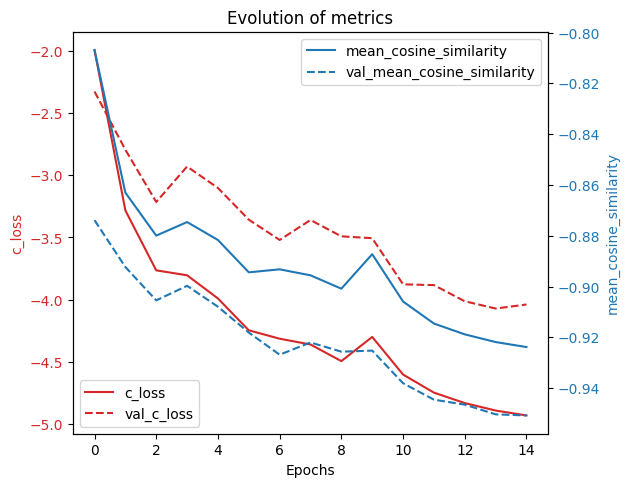

In [20]:
fig, ax1 = plt.subplots()

# Plotting c_loss
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('c_loss', color=color)
ax1.plot(pretraining_history.history['c_loss'] + pretraining_history_2.history['c_loss'], color=color, label='c_loss')
ax1.tick_params(axis='y', labelcolor=color)

# Plotting val_c_loss on the same ax1
ax1.plot(pretraining_history.history['val_c_loss'] + pretraining_history_2.history['val_c_loss'], color=color, linestyle='dashed', label='val_c_loss')

# Plotting mean_cosine_similarity on ax2
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('mean_cosine_similarity', color=color) 
ax2.plot(pretraining_history.history['mean_cosine_similarity'] + pretraining_history_2.history['mean_cosine_similarity'], color=color, label='mean_cosine_similarity')
ax2.tick_params(axis='y', labelcolor=color)

# Plotting val_mean_cosine_similarity on the same ax2
ax2.plot(pretraining_history.history['val_mean_cosine_similarity'] + pretraining_history_2.history['val_mean_cosine_similarity'], color=color, linestyle='dashed', label='val_mean_cosine_similarity')

# Add legends
ax1.legend(loc='lower left')
ax2.legend(loc='upper right')

fig.tight_layout()  # to ensure the layout fits into the figure area
plt.title('Evolution of metrics')
plt.show()


Train the classification head

In [14]:
# Freeze the encoder weights
pretraining_model.encoder.trainable = False

# Create a new classification model
encoder_output = pretraining_model.encoder(pretraining_model.encoder.layers[0].input)
classification_model = keras.Model(
    inputs=pretraining_model.encoder.layers[0].input,
    outputs=pretraining_model.classification_head(encoder_output)
)
classification_model.summary(show_trainable=True, expand_nested=True)

classification_model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

classification_history = classification_model.fit(ds_train.repeat(), epochs=5, validation_data=ds_val, steps_per_epoch=int((0.7*ds_size) // batch_size))

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_enc (InputLayer)      │ (None, 64, 64, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ encoder (Sequential)        │ (None, 128)           │  1,142,848 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ conv1_enc (Conv2D)     │ (None, 64, 64, 32)    │        896 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ pool1_enc              │ (None, 32, 32, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn1_enc                │ (None, 32, 32, 32)    │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ conv2_enc (Conv2D)     │ (None, 32, 32, 64)    │     18,496 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ pool2_enc              │ (None, 16, 16, 64)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn2_enc                │ (None, 16, 16, 64)    │        256 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ conv3_enc (Conv2D)     │ (None, 16, 16, 128)   │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ pool3_enc              │ (None, 8, 8, 128)     │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn3_enc                │ (None, 8, 8, 128)     │        512 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ flatten (Flatten)      │ (None, 8192)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ fc1_enc (Dense)        │ (None, 128)           │  1,048,704 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Classification_head         │ (None, 30)            │     20,894 │   Y   │
│ (Sequential)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_3 (Dense)        │ (None, 128)           │     16,512 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ batch_normalization_2  │ (None, 128)           │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_4 (Dense)        │ (None, 30)            │      3,870 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 1,163,742 (4.44 MB)

 Trainable params: 20,638 (80.62 KB)

 Non-trainable params: 1,143,104 (4.36 MB)

Epoch 1/5
356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.4852 - loss: 2.0429

2024-06-13 10:50:33.403125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 69s 193ms/step - accuracy: 0.4859 - loss: 2.0406 - val_accuracy: 0.9372 - val_loss: 0.4427
Epoch 2/5
  1/356 ━━━━━━━━━━━━━━━━━━━━ 57s 162ms/step - accuracy: 1.0000 - loss: 0.2836

2024-06-13 10:50:38.250122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9555 - loss: 0.2957

2024-06-13 10:51:39.580656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 66s 186ms/step - accuracy: 0.9555 - loss: 0.2955 - val_accuracy: 0.9851 - val_loss: 0.1142
Epoch 3/5
  1/356 ━━━━━━━━━━━━━━━━━━━━ 56s 159ms/step - accuracy: 1.0000 - loss: 0.0759

2024-06-13 10:51:44.583906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9896 - loss: 0.1007

2024-06-13 10:52:45.338680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 66s 184ms/step - accuracy: 0.9896 - loss: 0.1007 - val_accuracy: 0.9950 - val_loss: 0.0529
Epoch 4/5


2024-06-13 10:52:50.209703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9943 - loss: 0.0514

2024-06-13 10:53:51.290838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 66s 185ms/step - accuracy: 0.9943 - loss: 0.0514 - val_accuracy: 0.9932 - val_loss: 0.0298
Epoch 5/5
  1/356 ━━━━━━━━━━━━━━━━━━━━ 56s 160ms/step - accuracy: 1.0000 - loss: 0.0134

2024-06-13 10:53:56.140008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9986 - loss: 0.0271

2024-06-13 10:54:58.006746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


356/356 ━━━━━━━━━━━━━━━━━━━━ 67s 188ms/step - accuracy: 0.9986 - loss: 0.0271 - val_accuracy: 0.9981 - val_loss: 0.0176


2024-06-13 10:55:02.955806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Evaluate the model 

In [15]:
evaluation = classification_model.evaluate(ds_test)

# Print the evaluation metrics
print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy: {:.2f}%".format(evaluation[1]*100))

      7/Unknown 5s 21ms/step - accuracy: 1.0000 - loss: 0.0064

2024-06-13 10:55:07.887506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1630/1630 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - accuracy: 0.9938 - loss: 0.0240
Evaluation Loss: 0.01970786042511463
Evaluation Accuracy: 99.63%


2024-06-13 10:55:41.403649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
